In [25]:
#######################
# Importing Libraries #
#######################

#--Adding Data Types--#
import numpy as np
import pandas as pd

#--Processing--#
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#--RandomForest--#
from sklearn.ensemble import RandomForestRegressor

#--Gradient Boosting--#
from sklearn.ensemble import GradientBoostingRegressor

#--Extreme Gradient Boosting--#
from xgboost import XGBRegressor
from xgboost import plot_importance

#--Linear ElasticNet Regression--#
from sklearn.linear_model import ElasticNet

#--Pipeline For Stacking--#
from sklearn.pipeline import make_pipeline

#--Error Metric--#
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

#--Optimization--#
from bayes_opt import BayesianOptimization

#--Visualizations--#
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 100)

# Data Preperation For Tree's

In [3]:
####################
# Loading the Data #
####################

train_clean = pd.read_csv("train_clean.csv")
test_clean = pd.read_csv("test_clean.csv")

print("Training Dimensions: ", train_clean.shape)
print("Testing Dimensions: ", test_clean.shape)

######################
# Getting Id Columns #
######################
colId = pd.read_csv("test.csv")
colId = colId.Id

Training Dimensions:  (1460, 65)
Testing Dimensions:  (1459, 64)


In [4]:
####################################
# Applying Transforms to Functions #
####################################

train_clean['SalePrice'] = train_clean['SalePrice'].apply(lambda x: np.log(x + 1))
train_clean['GarageArea'] = train_clean['GarageArea'].apply(lambda x: np.log(x + 1))
train_clean['X2ndFlrSF'] = train_clean['X2ndFlrSF'].apply(lambda x: np.log(x + 1))
train_clean['TotalBsmtSF'] = train_clean['TotalBsmtSF'].apply(lambda x: np.log(x + 1))

test_clean['GarageArea'] = test_clean['GarageArea'].apply(lambda x: np.log(x + 1))
test_clean['X2ndFlrSF'] = test_clean['X2ndFlrSF'].apply(lambda x: np.log(x + 1))
test_clean['TotalBsmtSF'] = test_clean['TotalBsmtSF'].apply(lambda x: np.log(x + 1))



for c in train_clean.columns:
    if train_clean[c].dtype == 'object':
        le = LabelEncoder()
        # Need to convert the column type to string in order to encode missing values
        train_clean[c] = le.fit_transform(train_clean[c].astype(str))
for c in test_clean.columns:
    if test_clean[c].dtype == 'object':
        le = LabelEncoder()
        # Need to convert the column type to string in order to encode missing values
        test_clean[c] = le.fit_transform(test_clean[c].astype(str))

In [5]:
# ########################
# # Altering the DataSet # (These changes are based on the feature importances by the models, to be commented out later)
# ########################

# # Random Forest Features #
# ##########################
# train_clean.drop(rf_lowest_features, axis = 1, inplace = True)
# test_clean.drop(rf_lowest_features, axis = 1, inplace = True)

# # Gradient Boosting Features # (These changes lowered both our Jupyter RMSE and our Kaggle Score)
# ##############################

# train_clean.drop(gb_removals, axis = 1, inplace = True)
# test_clean.drop(gb_removals, axis = 1, inplace = True)

In [6]:
##################
# Splitting Data #  #(Only splitting the training data into two more sets called train_set, and test_set)
##################

train_set, test_set = train_test_split(train_clean, test_size = 0.2, random_state = 42)

print(train_set.shape)
print(test_set.shape)

X_train = train_set.drop("SalePrice", axis = 1)
Y_train = train_set.SalePrice

X_test = test_set.drop("SalePrice", axis = 1)
Y_test = test_set.SalePrice

#########################################
# The Full Original Training Set to Use #
#########################################

X_full_train = train_clean.drop("SalePrice", axis = 1)
Y_full_train = train_clean.SalePrice

(1168, 65)
(292, 65)


# Random Forest Section

In [ ]:
#################################################
# RandomForest Model To See Best Features Split #
#################################################
mse = []
for i in range(1,65):
    randForest = RandomForestRegressor(n_estimators=1000, min_samples_leaf= 5, 
                                       max_features=i, oob_score = True, random_state=42, n_jobs=3)
    randForest.fit(X_train, Y_train)
    forestPredictions = randForest.predict(X_test)
    mse.append(mean_squared_error(Y_test, forestPredictions))

In [ ]:
############################################
# Just to See The Index of the Lowest Tree #
############################################
lowest = 100000
index = 100000
for i,k in enumerate(mse):
    if k < lowest:
        lowest = k
        index = i
print(index, ':', lowest**0.5)

In [ ]:
############################################
# Running the Forest on The Whole Training #
############################################

randForest = RandomForestRegressor(n_estimators=10000, min_samples_leaf= 5, 
                                       max_features=48, oob_score = True, random_state=42, n_jobs=3)
randForest.fit(X_full_train, Y_full_train)

In [ ]:
###################################################
# Predicting The Kaggle DataSet with RandomForest #
###################################################

KagglePredictions = randForest.predict(test_clean)
KagglePredictions = [np.exp(x) - 1 for x in KagglePredictions]
pd.DataFrame({"SalePrice":KagglePredictions, "Id": colId}).to_csv("KaggleSubmitPythonForest.csv", index = False)
print(KagglePredictions[0:5])

# Gradient Boosting Section

In [ ]:
################################
# Setting Up Gradient Boosting #
################################

def gradBoostCV(n_estimators, max_depth, max_features, min_samples_leaf):
    val = cross_val_score(GradientBoostingRegressor(
    n_estimators = int(n_estimators), max_depth = int(max_depth), max_features = int(max_features), min_samples_leaf = int(min_samples_leaf),
        random_state = 42, learning_rate = 0.05
    ),X_train, Y_train, scoring = 'neg_mean_squared_error', cv = 10, n_jobs = 3).mean()
    return val

gradBoostBaye = BayesianOptimization(gradBoostCV, {
    'n_estimators': (100, 10000),
    'max_depth': (1,15),
    "max_features": (1,65),
    'min_samples_leaf': (5,10)
})

In [ ]:
gradBoostBaye.maximize(n_iter=30)

In [ ]:
print('Final Results')
print('Gradient Boosting: ', gradBoostBaye.res['max']['max_val'])
print('Gradient Boosting: ', gradBoostBaye.res['max']['max_params'])

In [7]:
################################
# MSE of Running the GradBoost #
################################

testGradBoost = GradientBoostingRegressor(n_estimators=2955, max_depth=3, max_features=2, min_samples_leaf = 5,
                                          random_state=42, subsample = 0.7, learning_rate=0.05)
testGradBoost.fit(X_train, Y_train)
testGradBoostPredictions = testGradBoost.predict(X_test)
mean_squared_error(Y_test, testGradBoostPredictions) ** 0.5

0.13600436426254062

In [10]:
#############################
# Running Gradient Boosting #
#############################

gradBoost = GradientBoostingRegressor(n_estimators=1368, max_depth=2, max_features=5,  min_samples_leaf = 5, subsample = 0.7,
                                      random_state=42, learning_rate=0.05)
gradBoost.fit(X_full_train, Y_full_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=2, max_features=5,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1368, presort='auto', random_state=42,
             subsample=0.7, verbose=0, warm_start=False)

In [11]:
########################################################
# Predicting The Kaggle DataSet with Gradient Boosting #
########################################################

KagglePredictionsGradBoost = gradBoost.predict(test_clean)
KagglePredictionsGradBoost = [np.exp(x) - 1 for x in KagglePredictionsGradBoost]
pd.DataFrame({"SalePrice":KagglePredictionsGradBoost, "Id": colId}).to_csv("KaggleSubmitPythonGradBoost.csv", index = False)
print(KagglePredictionsGradBoost[0:5])

[123330.37922071009, 159416.2582794209, 180384.21570001871, 198927.16478164637, 187712.3331718001]


# XG Boost Section

In [ ]:
###########################
# Setting Up XG Boosting #
###########################

def xgBoostCV(n_estimators, max_depth, gamma, min_child_weight):
    val = cross_val_score(XGBRegressor(n_estimators=int(n_estimators), max_depth=int(max_depth), 
                                      gamma = gamma, min_child_weight = min_child_weight, learning_rate = 0.05),
                          X_train, Y_train, scoring = 'neg_mean_squared_error', 
                          cv = 10, n_jobs = 3).mean()
    return val

xgBoostBaye = BayesianOptimization(xgBoostCV, {
    'n_estimators': (100, 10000),
    'max_depth': (1,30),
    "gamma": (0,50),
    'min_child_weight': (1,50)
})

In [ ]:
xgBoostBaye.maximize(n_iter=15)

In [ ]:
print('Final Results')
print('XG Boosting: ', xgBoostBaye.res['max']['max_val'])
print('XG Boosting: ', xgBoostBaye.res['max']['max_params'])

In [12]:
###############################
# MSE of Running the XG Boost #
###############################

testXGBoost = XGBRegressor(n_estimators=2724, max_depth=30, gamma=0, min_child_weight = 4, learning_rate=0.05, nthread = 3)
testXGBoost.fit(X_train, Y_train)
testXGBoostPredictions = testXGBoost.predict(X_test)
mean_squared_error(Y_test, testXGBoostPredictions) ** 0.5

0.13642273111904224

In [13]:
#######################
# Running XG Boosting #
#######################

XGBoost = XGBRegressor(n_estimators=2724, max_depth=30, gamma = 0, min_child_weight=4, learning_rate=0.05, nthread = 3)
XGBoost.fit(X_full_train, Y_full_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=30,
       min_child_weight=4, missing=None, n_estimators=2724, nthread=3,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [14]:
##################################################
# Predicting The Kaggle DataSet with XG Boosting #
##################################################

KagglePredictionsXGBoost = XGBoost.predict(test_clean)
KagglePredictionsXGBoost = [np.exp(x) - 1 for x in KagglePredictionsXGBoost]
pd.DataFrame({"SalePrice":KagglePredictionsXGBoost, "Id": colId}).to_csv("KaggleSubmitPythonXGBoost.csv", index = False)
print(KagglePredictionsXGBoost[0:5])

[120856.078125, 161563.9375, 187823.234375, 193709.671875, 179868.703125]


# Data Preparation For Linear

In [ ]:
####################
# Loading the Data #
####################

train_clean_2 = pd.read_csv("train_clean.csv")
test_clean_2 = pd.read_csv("test_clean.csv")

print("Training Dimensions: ", train_clean_2.shape)
print("Testing Dimensions: ", test_clean_2.shape)

######################
# Getting Id Columns #
######################
colId_2 = pd.read_csv("test.csv")
colId_2 = colId_2.Id

In [ ]:
####################################
# Applying Transforms to Functions #
####################################

full_one_hot = pd.concat([train_clean_2, test_clean_2])
full_one_hot['SalePrice'] = full_one_hot['SalePrice'].apply(lambda x: np.log(x+1))
full_one_hot['GarageArea'] = full_one_hot['GarageArea'].apply(lambda x: np.log(x+1))
full_one_hot['X2ndFlrSF'] = full_one_hot['X2ndFlrSF'].apply(lambda x: np.log(x+1))
full_one_hot['TotalBsmtSF'] = full_one_hot['TotalBsmtSF'].apply(lambda x: np.log(x+1))

####################
# Random Deletions #
####################
full_one_hot.drop('GarageArea', axis = 1, inplace=True)
full_one_hot.drop('GrLivArea', axis = 1, inplace=True)

###########################
# End of Random Deletions #
###########################

full_one_hot = pd.get_dummies(full_one_hot, drop_first=True, dummy_na=True)

one_hot_train = full_one_hot[0:1460]
one_hot_test = full_one_hot[1460:].drop('SalePrice', axis = 1)

In [ ]:
one_hot_test.tail()

In [ ]:
##################
# Splitting Data #  #(Only splitting the training data into two more sets called train_set, and test_set)
##################

train_set_2, test_set_2 = train_test_split(one_hot_train, test_size = 0.2, random_state = 42)

print("Train Shape: ", train_set_2.shape)
print("Test Shape: ", test_set_2.shape)

X_train_2 = train_set_2.drop("SalePrice", axis = 1)
Y_train_2 = train_set_2.SalePrice

X_test_2 = test_set_2.drop("SalePrice", axis = 1)
Y_test_2 = test_set_2.SalePrice

#########################################
# The Full Original Training Set to Use #
#########################################

X_full_train_2 = one_hot_train.drop("SalePrice", axis = 1)
Y_full_train_2 = one_hot_train.SalePrice
print("Full Shape: ", X_full_train_2.shape)

# Linear Regression Section

In [ ]:
def LinRegCV(alpha, l1_ratio):
    val = cross_val_score(make_pipeline(StandardScaler(), ElasticNet(alpha = alpha, l1_ratio = l1_ratio, random_state=42)),
                         X_train_2, Y_train_2, scoring = 'neg_mean_squared_error', 
                          cv = 10, n_jobs = 3).mean()
    return val

LinRegBaye = BayesianOptimization(LinRegCV,{
    'alpha': (0,1),
    'l1_ratio': (0,1)
})

In [ ]:
LinRegBaye.maximize(n_iter=30)

In [ ]:
print('Final Results')
print('Linear Regression: ', LinRegBaye.res['max']['max_val'])
print('Linear Regression: ', LinRegBaye.res['max']['max_params'])

In [ ]:
########################################
# MSE of Running the Linear Regression #
########################################

testLinReg = make_pipeline(StandardScaler(), ElasticNet(alpha = 0.51496038449599246, l1_ratio = 0, random_state=42))
testLinReg.fit(X_train_2, Y_train_2)
testLinRegPredictions = testLinReg.predict(X_test_2)
# print(testLinRegPredictions[:20])
mean_squared_error(Y_test_2, testLinRegPredictions)**.5

# testLinReg = Ridge(random_state=42, tol=0.000000001)
# testLinReg.fit(X_train_2, Y_train_2)
# testLinRegPredictions = testLinReg.predict(X_test_2)
# print(testLinRegPredictions[:20])
# print(mean_squared_error(Y_test_2, testLinRegPredictions)**.5)

In [ ]:
#############################
# Running Linear Regression #
#############################

LinReg = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.51496038449599246, l1_ratio = 0.0, random_state=42))
LinReg.fit(X_full_train_2, Y_full_train_2)

In [ ]:
########################################################
# Predicting The Kaggle DataSet with Linear Regression #
########################################################

KagglePredictionsLinReg = LinReg.predict(one_hot_test)
KagglePredictionsLinReg = [np.exp(x) - 1 for x in KagglePredictionsLinReg]
pd.DataFrame({"SalePrice":KagglePredictionsLinReg, "Id": colId_2}).to_csv("KaggleSubmitPythonLinReg.csv", index = False)
print(KagglePredictionsLinReg[0:5])

# Visualizations Area

In [ ]:
####################################
# The Importances of RandomForests #
####################################

rf_importances = randForest.feature_importances_
rf_importances = pd.DataFrame({"Features": X_full_train.columns, "Importances": rf_importances})
rf_importances = rf_importances.sort_values(by = "Importances", ascending=False)

rf_lowest_features = list(rf_importances.Features.tail().values)

plt.rcParams['figure.figsize'] = (16, 12)
plt.xticks(rotation =90)
# plt.ylim([0,0.04])

barplot_ypos = np.arange(len(rf_importances.Features))
plt.bar(barplot_ypos, rf_importances.Importances, align = 'center')
plt.xticks(barplot_ypos, rf_importances.Features)
plt.xlabel('Feature Name')
plt.ylabel('Relative Importance')
plt.title('Importance vs. Feature')
plt.show()

In [ ]:
########################################
# The Importances of Gradient Boosting #
########################################

gb_importances = gradBoost.feature_importances_

gb_importances = pd.DataFrame({"Features": X_full_train.columns, "Importances": gb_importances})
gb_importances = gb_importances.sort_values(by = "Importances", ascending = True)

gb_lowest_features = list(gb_importances.Features.tail().values)
gb_removals = list(gb_importances.Features.tail()[-1:-3:-1])

plt.rcParams['figure.figsize'] = (16, 16)
# plt.xticks(rotation =90)

barplot_ypos = np.arange(len(gb_importances.Features))
plt.barh(barplot_ypos, gb_importances.Importances, align = 'center')
plt.yticks(barplot_ypos, gb_importances.Features)
plt.ylabel('Feature Name')
plt.xlabel('Relative Importance')
plt.title('Importance vs. Feature')
# plt.show()

plt.savefig('GradBoost.png')

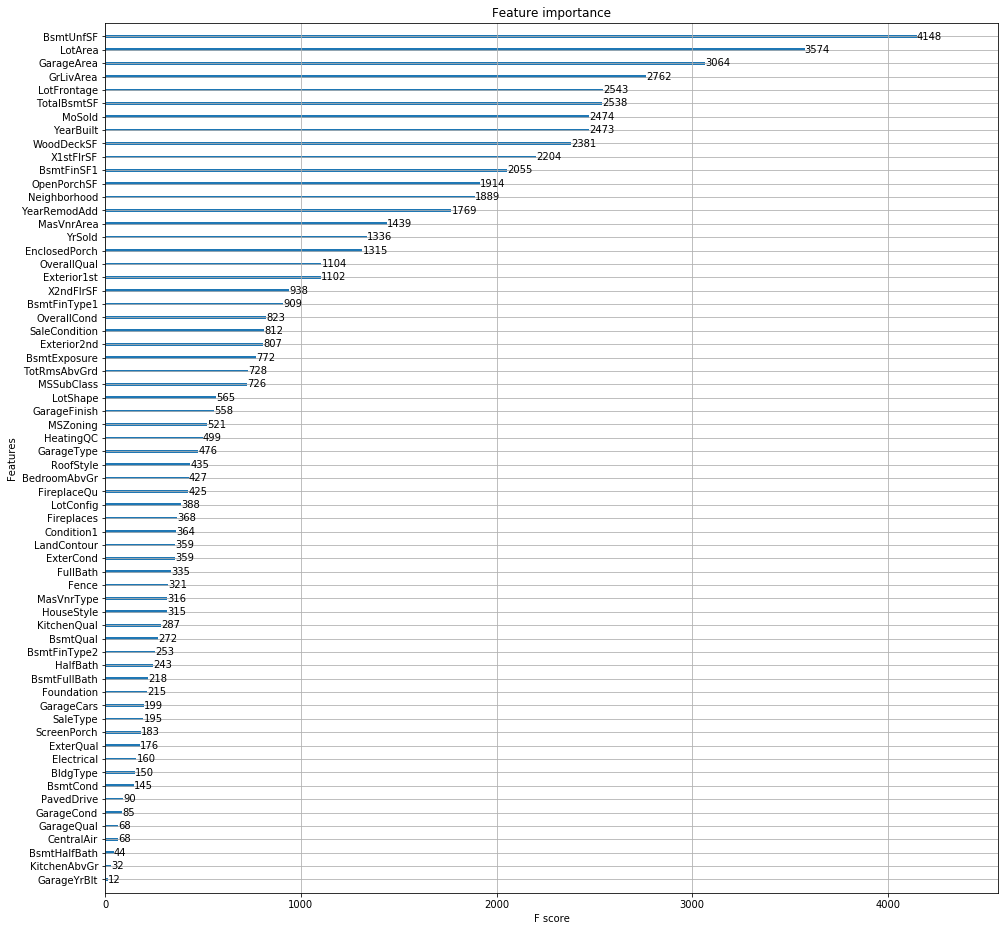

In [30]:
###############################################
# The Importances of Xtreme Gradient Boosting #
###############################################

plt.rcParams['figure.figsize'] = (16, 16)
plot_importance(XGBoost)
plt.savefig('XGBoost.png')

In [ ]:
# blah = np.sum([KagglePredictions, KagglePredictionsGradBoost, KagglePredictionsXGBoost], axis = 0)/3

In [ ]:
# pd.DataFrame({"SalePrice":blah, "Id": colId}).to_csv("KaggleSubmitPythonBlah.csv", index = False)

# Testing Stuff (It all failed at lowering Score)

In [ ]:

# def gradBoostCV2(n_estimators, max_depth, max_features, min_samples_leaf):
#     val = cross_val_score(GradientBoostingRegressor(
#     n_estimators = int(n_estimators), max_depth = int(max_depth), max_features = int(max_features), min_samples_leaf = int(min_samples_leaf),
#         random_state = 42, learning_rate = 0.05
#     ),X_train_2, Y_train_2, scoring = 'neg_mean_squared_error', cv = 5, n_jobs = 3).mean()
#     return val

# gradBoostBaye2 = BayesianOptimization(gradBoostCV2, {
#     'n_estimators': (100, 10000),
#     'max_depth': (1,15),
#     "max_features": (1,63),
#     'min_samples_leaf': (5,10)
# })

In [ ]:
# gradBoostBaye2.maximize(n_iter=10)

In [ ]:
# print('Final Results')
# print('Gradient Boosting: ', gradBoostBaye2.res['max']['max_val'])
# print('Gradient Boosting: ', gradBoostBaye2.res['max']['max_params'])

In [ ]:
# testGradBoost2 = GradientBoostingRegressor(n_estimators=3437, max_depth=7, max_features=30, min_samples_leaf = 7,
#                                           random_state=42, learning_rate=0.05)
# testGradBoost2.fit(X_train_2, Y_train_2)
# testGradBoostPredictions2 = testGradBoost2.predict(X_test_2)
# mean_squared_error(Y_test_2, testGradBoostPredictions2) ** 0.5

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline

In [ ]:
# correlations = train_clean_2.corr()
# # plot correlation matrix
# # fig = plt.figure()
# # ax = fig.add_subplot(111)
# # cax = ax.matshow(correlations, vmin=-1, vmax=1)
# # fig.colorbar(cax)
# # ticks = np.arange(0,9,1)
# # ax.set_xticks(ticks)
# # ax.set_yticks(ticks)
# # plt.show()
# for i in correlations:
#     for j in range(len(correlations)):
#         x = abs(correlations[i][j])
#         if x >= 0.8 and x != 1:
#             print(i, j, x)